In [2]:
import fastf1 as ff1
from fastf1 import plotting

import pandas as pd

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import cm
from matplotlib.patches import Rectangle, Polygon
import matplotlib.image as mpimg

import numpy as np
import re

from matplotlib.image import imread
from PIL import Image

In [3]:
ff1.Cache.enable_cache('./cache')
pd.options.mode.chained_assignment = None

In [22]:
year, event, event_type = 2023, 'miami', 'R'
session = ff1.get_session(year, event, event_type)
session.load()

core           INFO 	Loading data for Miami Grand Prix - Race [v3.0.0]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '14', '63', '55', '44', '16', '10', '31', '20', '22', '18', '77', '23', '27', '24', '4', '21', '81', '2']


In [25]:
laps = session.laps

In [26]:
# Convert laptimes to seconds
laps['LapTimeSeconds'] = laps['LapTime'].dt.total_seconds()

# To get accurate laps only, we exclude in- and outlaps
laps = laps.loc[(laps['PitOutTime'].isnull() & laps['PitInTime'].isnull())]

In [27]:
# Also, we remove outliers since those don't represent the racepace,
# using the Inter-Quartile Range (IQR) proximity rule
q75, q25 = laps['LapTimeSeconds'].quantile(0.75), laps['LapTimeSeconds'].quantile(0.25)

intr_qr = q75 - q25

laptime_max = q75 + (1.5 * intr_qr) # IQR proximity rule: Max = q75 + 1,5 * IQR
laptime_min = q25 - (1.5 * intr_qr) # IQR proximity rule: Min = q25 + 1,5 * IQR

laps.loc[laps['LapTimeSeconds'] < laptime_min, 'LapTimeSeconds'] = np.nan
laps.loc[laps['LapTimeSeconds'] > laptime_max, 'LapTimeSeconds'] = np.nan

In [154]:
# Columns to keep
columns_to_keep = ['DriverNumber', 'BroadcastName', 'Abbreviation', 'DriverId', 'TeamName']

# Top 5
# top_five = session.results.loc[:, columns_to_keep].head(5)
# for i in top_five:
#     drivers_to_visualize = top_five['Abbreviation']
#
# Top 10
# top_ten = session.results.loc[:, columns_to_keep].head(10)
# for i in top_ten:
#     drivers_to_visualize = top_ten['Abbreviation']
# Top 15
top_fifteen = session.results.loc[:, columns_to_keep].head(15)
for i in top_fifteen:
    drivers_to_visualize = top_fifteen['Abbreviation']

drivers_to_visualize = drivers_to_visualize.head(15)

In [155]:
number_to_word = {
    5: "Five",
    10: "Ten",
    15: "Fifteen",
    20: "Twenty"
}

In [156]:
plot_width = 10
plot_height = 10
plot_size = [plot_width, plot_height]
title_font_size = int(2 * plot_height)  # Adjust the 0.15 multiplier to your liking
axis_label_font_size = int(1.5 * plot_height)  # Adjust the 0.1 multiplier to your liking
autolayout = True
# plot_title = f"{session.event.year} {session.event.EventName} - Race Pace \n Top Three Teams & Drivers Analysis"
driver_count_word = ""
if len(drivers_to_visualize) in number_to_word:
    driver_count_word = number_to_word[len(drivers_to_visualize)]
plot_title = f"{session.event.year} {session.event.EventName} - Race Pace Analysis Top {driver_count_word}"
# plot_ratios = [7,7]
plot_filename = re.sub(r'\W+', '', plot_title.replace("\n", " ")) + ".png"
logo_path = r'C:\Users\getou\Desktop\F1DataVisualization\RCKMG_logo.png'
logo_img = Image.open(logo_path)

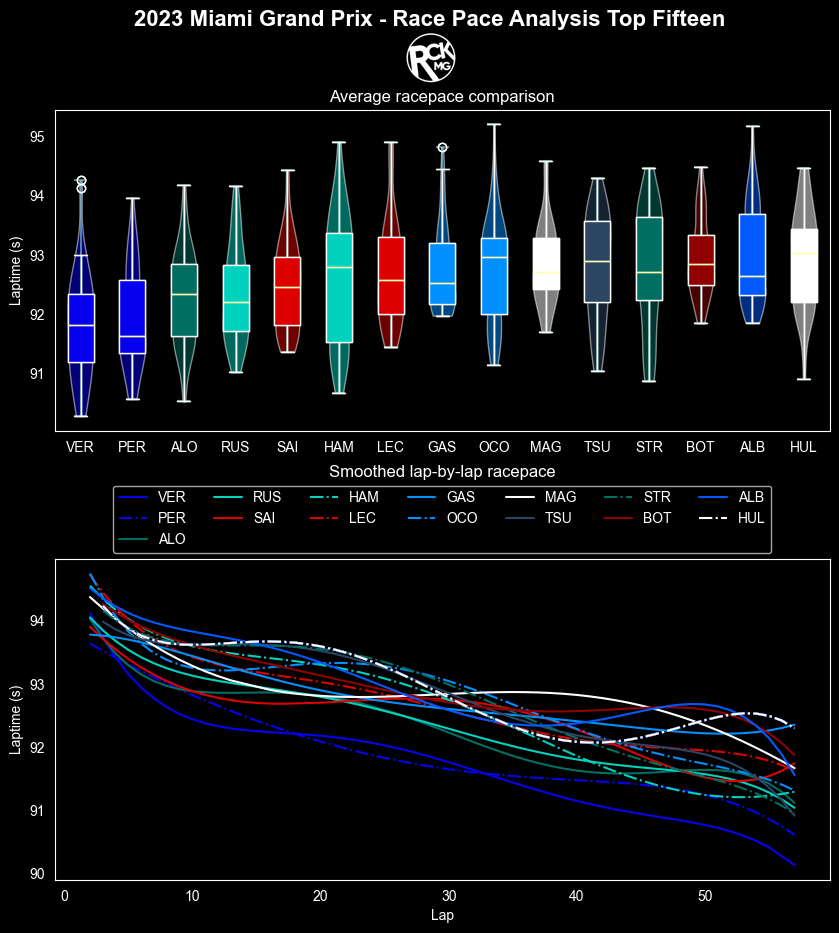

In [164]:
# To make sure we won't get any equally styled lines when comparing teammates
visualized_teams = []

# Make plot a bit bigger
plt.rcParams['figure.figsize'] = plot_size
plt.style.use('dark_background')

# Create 2 subplots (1 for the boxplot, 1 for the lap-by-lap comparison)
fig, ax = plt.subplots(2)
fig.suptitle(plot_title, fontsize=16, fontweight='bold')
##############################
# Boxplot for average racepace
##############################
laptimes = [laps.pick_driver(x)['LapTimeSeconds'].dropna() for x in drivers_to_visualize] 

ax[0].boxplot(laptimes, labels=drivers_to_visualize)

ax[0].set_title('Average racepace comparison')
ax[0].set(ylabel = 'Laptime (s)')

##############################
# Violin plot for average racepace
##############################
laptimes = [laps.pick_driver(x)['LapTimeSeconds'].dropna() for x in drivers_to_visualize]

violin_parts = ax[0].violinplot(laptimes, showmedians=True)

# adjust the alpha of the body of the violin plot
for pc in violin_parts['bodies']:
    pc.set_alpha(0.5)  # adjust as necessary

# adjust the alpha of other parts of the violin plot
for partname in ('cbars','cmins','cmaxes','cmedians'):
    vp = violin_parts[partname]
    vp.set_alpha(0.6)  # adjust as necessary

ax[0].set_title('Average racepace comparison')
ax[0].set(ylabel = 'Laptime (s)')

# Customize x-axis labels
ax[0].set_xticks([y + 1 for y in range(len(drivers_to_visualize))])
ax[0].set_xticklabels(drivers_to_visualize)

# Coloring the violin plots
for patch, color in zip(ax[0].collections, [team_colors[driver] for driver in drivers_to_visualize]):
    patch.set_facecolor(color)


##############################
# Lap-by-lap racepace comparison
##############################
for driver in drivers_to_visualize:
    driver_laps = laps.pick_driver(driver)[['LapNumber', 'LapTimeSeconds', 'Team']]

    # Select all the laps from that driver
    driver_laps = driver_laps.dropna()

    # Extract the team for coloring purploses
    team = pd.unique(driver_laps['Team'])[0]

    # X-coordinate is the lap number
    x = driver_laps['LapNumber']

    # Y-coordinate a smoothed line between all the laptimes
    poly = np.polyfit(driver_laps['LapNumber'], driver_laps['LapTimeSeconds'], 5)
    y_poly = np.poly1d(poly)(driver_laps['LapNumber'])

    # Make sure that two teammates don't get the same line style
    linestyle = '-' if team not in visualized_teams else 'dashdot'

    # Plot the data
    ax[1].plot(x, y_poly, label=driver, color=ff1.plotting.team_color(team), linestyle=linestyle)

    # Include scatterplot (individual laptimes)
    # y = driver_laps['LapTimeSeconds']
    # scatter_marker = 'o' if team not in visualized_teams else '^'
    # ax[1].scatter(x, y, label=driver, color=ff1.plotting.team_color(team), marker=scatter_marker)

    # Append labels
    ax[1].set(ylabel = 'Laptime (s)')
    ax[1].set(xlabel = 'Lap')

    # Set title
    ax[1].set_title('Smoothed lap-by-lap racepace', y=1.23)

    # Generate legend
    # Calculate the center position for the legend
    legend_x = 0.5
    legend_y = 1.25

    # Create the legend
    ax[1].legend(loc='upper center', bbox_to_anchor=(legend_x, legend_y), ncol=len(drivers_to_visualize)//2)
    # Add the team to the visualized teams variable so that the next time the linestyle will be different
    visualized_teams.append(team)

    # Create a dictionary to store the team colors for each driver
team_colors = {driver: ff1.plotting.team_color(pd.unique(laps.pick_driver(driver)['Team'])[0]) for driver in drivers_to_visualize}

# Boxplot for average racepace
box = ax[0].boxplot(laptimes, labels=drivers_to_visualize, patch_artist=True)

# Color the boxplots
for patch, driver in zip(box['boxes'], drivers_to_visualize):
    patch.set_facecolor(team_colors[driver])

    
# Define the new width and height for the logo
new_width = 50
new_height = 50
# Resize the logo
logo_resized = logo_img.resize((new_width, new_height))
logo_resized_np = np.array(logo_resized)
logo_x = 406
logo_y = 850
fig.figimage(logo_resized_np, xo=logo_x, yo=logo_y, zorder=1, origin='upper', alpha=1)
fig.subplots_adjust(hspace=0.4)  # or whatever value you find suitable




# Lap-by-lap racepace comparison
for driver in drivers_to_visualize:

    # Plot the data
    ax[1].plot(x, y_poly, label=driver, color=team_colors[driver], linestyle=linestyle)

# plt.savefig(plot_filename, dpi=300)
ax[0].grid(False)
plt.grid(False)
plt.show()